Реализация SVM для бинарной классификации на Numpy

Значение оптимизируемого функционала $Q(X, y, w, b)$
$$Q(X, y, w, b)= C\cdot \sum\limits_{i=1}^N \max\{0, 1-y_i\cdot (<x_i, w> + b)\} \rightarrow \min\limits_{w, b}$$
Функционал негладкий, поэтому реализую субградиентный спуск.

In [2]:
import time
import numpy as np
import scipy
from scipy.special import expit
import scipy.sparse as sparse
from numpy.linalg import norm
import math


class SVMClassifier:

    def __init__(self, step_alpha=1, step_beta=0, tolerance=1e-5, 
                 max_iter=1000, l2_coef=1.0, C_coef=1.0, **kwargs):
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.l2_coef = l2_coef
        self.C_coef = C_coef
        self.history = {'weights': [], 'func': []}
        self.w = None
        self.b = None

    #вычисление значения функционала, соответсвующего безусловной задачи оптимизации для SVM
    #параметр self.C_coef нужно подбирать отдельно для каждой задачи
    #см. подробности https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture05-linclass.pdf
    #и в лекции Воронцова по SVM
    def func(self, X, y, w, b):
        #print(np.dot(X, w) + b)
        #print(y.shape)
        return self.C_coef * (np.maximum(1.0 - (np.dot(X, w) + b) * y, 
                          np.zeros(X.shape[0]))).sum() / X.shape[0] + self.l2_coef * 0.5 * norm(w) ** 2
    
    #вычисление градиента по весам
    def grad_w(self, X, y, w, b):
        gradient_coefficients = ((np.dot(X, w) + b) * y <= 1.0)
        #print(gradient_coefficients.sum())
        return (self.l2_coef * w - self.C_coef * 
                ((X * y[:, np.newaxis] * gradient_coefficients[:, np.newaxis]).T).sum(axis=1) 
                / X.shape[0]
                )
    
    #вычисление производной по параметру сдвига гиперплоскости
    def grad_b(self, X, y, w, b):
        gradient_coefficients = ((np.dot(X, w) + b) * y <= 1.0)
        return - self.C_coef * (y * gradient_coefficients).sum() / X.shape[0]
        
    def fit(self, X, y, w_0=None, b_0=None, trace=False):
        if w_0 is None:
            w_0 = np.ones(X.shape[1]) / X.shape[1]
            #w_0 = np.zeros(X.shape[1])
        if b_0 is None:
            b_0 = 0.0
        self.history['func'].append(self.func(X, y, w_0, b_0))
        
        self.w = w_0 - self.step_alpha * self.grad_w(X, y, w_0, b_0)
        self.b = b_0 - self.step_alpha * self.grad_b(X, y, w_0, b_0)
        self.history['func'].append(self.func(X, y, self.w, self.b))
        self.history['weights'].append(self.get_weights())

        if abs(self.history['func'][1] - self.history['func'][0]) < self.tolerance:
            return
        else:
            #градиентный спуск для минимизации функционала
            for k in range(2, self.max_iter+1):
                w_curr = self.w.copy()
                b_curr = self.b
                self.w = w_curr - (self.step_alpha / (k ** self.step_beta)) * self.grad_w(X, y, w_curr, b_curr)
                self.b = b_curr - (self.step_alpha / (k ** self.step_beta)) * self.grad_b(X, y, w_curr, b_curr)
                self.history['func'].append(self.func(X, y, self.w, self.b))
                self.history['weights'].append(self.get_weights())
                if abs(self.history['func'][k] - self.history['func'][k-1]) < self.tolerance:
                    return           
        
    def predict(self, X):
        R = np.sign(np.dot(X, self.w) + self.b)
        R[R == 0.] = 1
        return R

    #значение функционала    
    def get_objective(self, X, y):
        return self.func(X, y, self.w, self.b)
    
    #посмотреть веса обученя
    def get_weights(self):
        return np.hstack((self.w, self.b))
    
    

Создание выборки из make_blobs

In [19]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
%matplotlib inline

np.random.seed(119)
#создаю выборку
sample_size = 3000
X, y = make_blobs(sample_size, centers=2)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
#X = np.hstack((X, np.ones((X.shape[0], 1))))
y = (y - 0.5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

На трейне

От выбора коэффициента C и learning_rate зависит итоговая гиперплоскость (в том числе и в случае линейно разделимо выборки, так как решаю задачу оптимизации функционала), поэтому не всегда получается результат идеально соответсвующий определению гиперплоскости в SVM. Но как видно из следующей ячейки результат близкий. 

Weights: [-1.07047301  0.51464129  0.00225949]
Accuracy: 1.0
fit time: 0.07002799700012474
Угловой коэффициент: 2.0800371530205557
Значение функционала: 0.8224784172029735
[0.88753329 0.8848977  0.81308725 0.8576587  0.94251876 0.92723004
 0.85207422 0.93591277 0.79058378 0.91166743 0.89839372 0.88247612
 0.84153342 0.91273528 0.69246716 0.93349857]


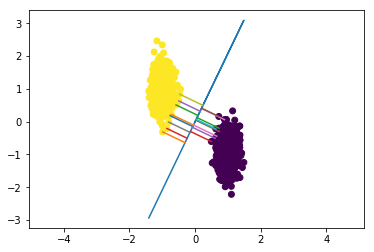

In [20]:
#c = 1 * X_train.shape[0]
c = 100
old_oracle = SVMClassifier(step_alpha=1.0, step_beta=1.0, 
                 tolerance=1e-5, max_iter=3000, l_2_coef=1.0, C_coef=c)
start = time.monotonic()
res = old_oracle.fit(X_train, y_train)
finish = time.monotonic()
weights = old_oracle.get_weights()
#делаю предсказания
pred = old_oracle.predict(X_train)
accuracy = (pred == y_train).sum() / y_train.shape[0]
print("Weights: " + str(weights))
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))
print("Угловой коэффициент: " + str(-weights[0] / weights[1]))
print("Значение функционала: " + str(old_oracle.history['func'][-1]))

#рисую опорные вектора: при идеальном обучении это в точности вектора до точек x_i:
# y_i*(<x_i, w> + b) = 1, но у меня эта 1 может варьироваться в силу приближённого решения
matr = (np.dot(X_train, weights[0:2]) + weights[2]) * y_train

#вот тут число надо менть в зависимости от задачи
new_mask = (matr <= 0.95 * np.ones(matr.shape[0]))
e = np.array([weights[0], weights[1]]) / norm(np.array([weights[0], weights[1]]))
sp = []
p = []
print(matr[new_mask])
for i in X_train[new_mask]:
    sp.append(i)
    d = abs(weights[0]*i[0] + weights[1]*i[1] + weights[2]) / (weights[0]**2 + weights[1]**2) **0.5
    if abs(weights[0]*(i+e*d)[0] + weights[1]*(i+e*d)[1] + weights[2]) > 0.01:
        p.append(i-e*d)
    else:
        p.append(i+e*d)
        

x = np.hstack((np.linspace(X[:, 0].min(), X[:, 0].max(), 1000), 0))
plt.plot(x, - (1 / weights[1]) * (weights[0] * x + weights[2]))
for i in range(len(sp)):
    plt.plot([sp[i][0], p[i][0]], [sp[i][1], p[i][1]])
#plt.plot(x, - (v[0]/v[1]) * (x - M[0]) + M[1])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.axis('equal')
plt.show()

Сравнение с SVC из sklearn

Weights: [-1.06863034  0.52274181  0.00398723]
Accuracy: 1.0
fit time: 0.11744618400007312
2.0442794488797924
0.8231022208715647


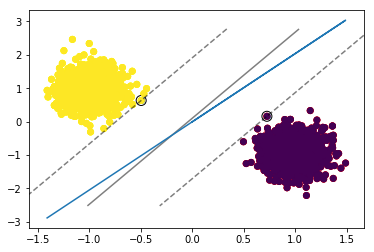

In [21]:
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
%matplotlib inline

model = SVC(kernel='linear', C=1E10)
model.fit(X_train, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='autumn')
plt.scatter(model.support_vectors_[:,0],model.support_vectors_[:,1])

ax = plt.gca()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 50)
yy = np.linspace(ylim[0], ylim[1], 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

old_oracle = SVMClassifier(step_alpha=1.0, step_beta=1.0, 
                 tolerance=1e-5, max_iter=300, l_2_coef=1.0, C_coef=c)
start = time.monotonic()
res = old_oracle.fit(X_train, y_train)
finish = time.monotonic()
weights = old_oracle.get_weights()
#делаю предсказания
pred = old_oracle.predict(X_train)
accuracy = (pred == y_train).sum() / y_train.shape[0]
print("Weights: " + str(weights))
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))
print(-weights[0] / weights[1])
print(old_oracle.history['func'][-1])

x = np.hstack((np.linspace(X[:, 0].min(), X[:, 0].max(), 1000), 0))
plt.plot(x, - (1 / weights[1]) * (weights[0] * x + weights[2]))
#plt.plot(x, - (v[0]/v[1]) * (x - M[0]) + M[1])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

plt.show()

Смотрю результат моего SVM на тесте

На тесте

Weights: [-1.06863034  0.52274181  0.00398723]
Accuracy: 1.0
fit time: 0.07465410599979805
2.0442794488797924
0.8231022208715647


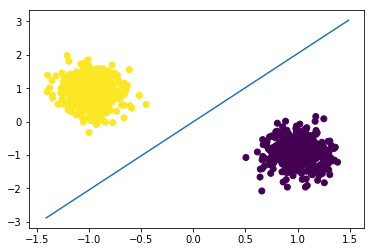

In [22]:
old_oracle = SVMClassifier(step_alpha=1.0, step_beta=1.0, 
                 tolerance=1e-5, max_iter=300, l_2_coef=1.0, C_coef=c)
start = time.monotonic()
res = old_oracle.fit(X_train, y_train)
finish = time.monotonic()
weights = old_oracle.get_weights()
#делаю предсказания
pred = old_oracle.predict(X_test)
accuracy = (pred == y_test).sum() / y_test.shape[0]
print("Weights: " + str(weights))
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))
print(-weights[0] / weights[1])
print(old_oracle.history['func'][-1])

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
plt.plot(x, - (1 / weights[1]) * (weights[0] * x + weights[2]))
#plt.plot(x, - (v[0]/v[1]) * (x - M[0]) + M[1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.show()

Ради интереса посмотрим на make_moons

In [24]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
%matplotlib inline
#создаю выборку
sample_size = 3000
#X, y = make_blobs(sample_size, centers=2, n_features=10)
X, y = make_moons(sample_size)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
#X = np.hstack((X, np.ones((X.shape[0], 1))))
y = (y - 0.5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Weights: [ 0.35959158 -0.50466207  0.01388218]
Accuracy: 0.8757575757575757
fit time: 0.0054379240000344
0.7125393517714748
0.6047303979611232


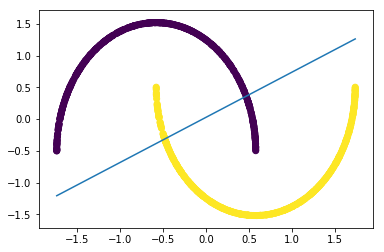

In [25]:
old_oracle = SVMClassifier(step_alpha=1.0, step_beta=1.0, 
                 tolerance=1e-5, max_iter=300, l_2_coef=1.0, C_coef=1.0)
start = time.monotonic()
res = old_oracle.fit(X_train, y_train)
finish = time.monotonic()
weights = old_oracle.get_weights()
#делаю предсказания
pred = old_oracle.predict(X_test)
accuracy = (pred == y_test).sum() / y_test.shape[0]
print("Weights: " + str(weights))
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))
print(-weights[0] / weights[1])
print(old_oracle.history['func'][-1])

x = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)
plt.plot(x, - (1 / weights[1]) * (weights[0] * x + weights[2]))
#plt.plot(x, - (v[0]/v[1]) * (x - M[0]) + M[1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.show()

Пробую свою модель на dataset-е из kaggle https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Загрузка и препроцессинг (файлы данных приложил)

In [26]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import scipy.sparse
import time
import matplotlib
%matplotlib inline

df = pd.read_csv("toxic_train.csv")
df = df[['Unnamed: 0', 'comment_text', 'is_toxic']]
df.columns = ['id', 'text', 'is_toxic']
df.loc[:, 'is_toxic'] = (df.loc[:, 'is_toxic'].astype('int') - 0.5) * 2
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: x.lower())
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: re.sub('[^а-яёa-z0-9]', ' ', x))
df.head()

,id,text,is_toxic
0,0,explanation why the edits made under my userna...,-1.0
1,1,d aww he matches this background colour i m s...,-1.0
2,2,hey man i m really not trying to edit war it...,-1.0
3,3,more i can t make any real suggestions on im...,-1.0
4,4,you sir are my hero any chance you remember...,-1.0


In [27]:
df_test = pd.read_csv("toxic_test.csv")
df_test.head()

df_test = df_test[['Unnamed: 0', 'comment_text', 'is_toxic']]
df_test.columns = ['id', 'text', 'is_toxic']
df_test.loc[:, 'is_toxic'] = (df_test.loc[:, 'is_toxic'].astype('int') - 0.5) * 2
df_test.loc[:, 'text'] = df_test.loc[:, 'text'].apply(lambda x: x.lower())
df_test.loc[:, 'text'] = df_test.loc[:, 'text'].apply(lambda x: re.sub('[^а-яёa-z0-9]', ' ', x))
df_test.head()

,id,text,is_toxic
0,0,thank you for understanding i think very high...,-1.0
1,1,dear god this site is horrible,-1.0
2,2,somebody will invariably try to add relig...,-1.0
3,3,it says it right there that it is a type ...,-1.0
4,4,before adding a new product to the lis...,-1.0


BagOfWords: выделяю признаки из текста

In [28]:
countvectorizer = CountVectorizer(min_df=0.01)
X_train = countvectorizer.fit_transform(df.loc[:, 'text']).toarray()
X_test = countvectorizer.transform(df_test.loc[:, 'text']).toarray()

In [29]:
y_train = df.loc[:, 'is_toxic'].values
y_test = df_test.loc[:, 'is_toxic'].values

Обучаюсь с константой C = 100  
Accuracy = 0.8 для сбалансированных классов и очень порезанном BagOfWords (оставляю только 600 слов из 90к в качестве признаков, т.к. иначе долго работает)

In [30]:
c = 100
old_oracle = SVMClassifier(step_alpha=1.0, step_beta=1.0, 
                 tolerance=1e-5, max_iter=300, l_2_coef=1.0, C_coef=c)
start = time.monotonic()
res = old_oracle.fit(X_train, y_train)
finish = time.monotonic()
weights = old_oracle.get_weights()
#делаю предсказания
pred = old_oracle.predict(X_test)
accuracy = (pred == y_test).sum() / y_test.shape[0]
#print("Weights: " + str(weights))
print("Accuracy: " + str(accuracy))
print("fit time: " + str(finish - start))
print(-weights[0] / weights[1])
print(old_oracle.history['func'][-1])

Accuracy: 0.8093441671503192
fit time: 179.6826643219997
-1.02439024390244
45.71047686258097


SVC от sklearn

In [ ]:
X_train.shape

In [6]:
X_train_new = scipy.sparse.csr_matrix(X_train)
X_test_new = scipy.sparse.csr_matrix(X_test)
X_test_new

<20676x568 sparse matrix of type '<class 'numpy.int64'>'
	with 460453 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
%matplotlib inline

model = SVC(kernel='linear', C=1e5, cache_size=10000)
model.fit(X_train_new, y_train)

pred = model.predict(X_test_new)
accuracy = (pred == y_test).sum() / y_test.shape[0]